# Setup

## Imports

In [1]:
import csv
import time
import os.path
import datetime
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()
import csv
import itertools
from scipy.stats import gaussian_kde
import math
import inspect
import graphviz
import pickle
import plotly.graph_objects as go
import pprint
import random
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import BaggingClassifier
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFE
import joblib
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, classification_report, matthews_corrcoef
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.ensemble._forest import _get_n_samples_bootstrap
from sklearn.ensemble._forest import _generate_sample_indices
from sklearn import tree

/Users/guillaume/prometheus/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
pd.options.mode.chained_assignment = None

## Functions

In [3]:
def predict_proba_daily_recal(model, X_train, y_train, X_test, y_test):
    """Output of model.predict_proba() but with daily recalibration"""
    test_dates = pd.to_datetime(X_test.index.str[:10], format="%d/%m/%Y")
    distinct_dates = test_dates.unique()
    y_probs_list =  []
    
    for date in tqdm(distinct_dates):
        # For every day in the test set, we add all past days to the training set
        X_train_new = pd.concat([X_train, X_test[test_dates < date]])
        y_train_new = pd.concat([y_train, y_test[test_dates < date]])
        # And we create a sub test set composed of that day only
        X_test_new = X_test[test_dates == date]
        y_test_new = y_test[test_dates == date]

        model.fit(X_train_new, y_train_new)
        
        y_probs = model.predict_proba(X_test_new)

        y_pred_new = (y_probs[:,1] >= 0.35).astype(bool) # Hard coded probability threshold that was optimised later in the notebook
        
        print("F1-score for day {} is {}".format(date, f1_score(y_test_new, y_pred_new)))
        print(confusion_matrix(y_test_new, y_pred_new))
        print("\n")
        y_probs_list.append(y_probs)
    
    return np.concatenate(y_probs_list, axis=0)

In [19]:
def find_best_prob_threshold(clf, X, y):
    """Find best probability threshold given a fitted classifier, a set of covariates X and a response y"""
    f1 = []
    pred_probs = clf.predict_proba(X)[:,1]
    for prob_thre in range(1,100):      
        y_pred = (pred_probs >= prob_thre / 100).astype(bool)
        f1.append(f1_score(y, y_pred))
    max_f1 = max(f1)
    argmax_f1 = f1.index(max_f1) / 100
    return max_f1, argmax_f1

In [4]:
def test_clf_CV(clf, X, y):
    """Test classifier with leave-one-month-out cross validation"""
    accuracy = []
    precision = []
    recall = []
    f1 = []
    threshold = []
    
    for month in trange(1, 12):
        
        train_X = X[X.index.str[3:5].astype(int) != month]
        test_X = X[X.index.str[3:5].astype(int) == month]
        train_y =  y[X.index.str[3:5].astype(int) != month]
        test_y =  y[X.index.str[3:5].astype(int) == month]
        print(f"Fitting leaving month {month} out...")
        clf.fit(train_X, train_y)
        
        _, thresh = find_best_prob_threshold(clf, test_X, test_y)
        threshold.append(thresh)
        print("Best threshold found is: {:.2f}".format(thresh))
        y_pred = clf.predict_proba(test_X)[:,1] > thresh
    
        accuracy.append(accuracy_score(test_y, y_pred))
        precision.append(precision_score(test_y, y_pred))
        recall.append(recall_score(test_y, y_pred))
        f1.append(f1_score(test_y, y_pred))
        
        print("Accuracy score is: {:.3f}".format(accuracy[-1]))
        print("Precision score is: {:.3f}".format(precision[-1]))
        print("Recall score is: {:.3f}".format(recall[-1]))
        print("F1 score is: {:.3f}\n".format(f1[-1]))

    score_df = pd.DataFrame({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'threshold': threshold
    }, index=range(1,12))

    return score_df

# Main

In [12]:
DBorig = pickle.load(open('DBdw_2019.pickle', "rb"))
DBorig = DBorig[DBorig.Tech!='UVAM']
DB = DBorig.copy()
#DB = DB.sample(n=100000)
DB['Result'].value_counts() # check su % accettati su totale

#DB = pickle.load(open('DBup_2019.pickle', "rb"))

Result
0.0    431219
1       70275
Name: count, dtype: int64

In [13]:
DB["date"] = pd.to_datetime(DB.index.str[:10], format="%d/%m/%Y")
DB.sort_values("date", inplace=True)
DB.drop(["date", "Target"], axis=1, inplace=True)

In [14]:
# We first of all create a test "hold-out" dataset corresponding to the last month, that we don't consider until the very end evaluation
test_DB = DB[DB.index.str[3:5] == '12']
DB = DB[DB.index.str[3:5] != '12']
test_DB.head(3)

,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,Result
idx,,,,,,,,,,,,,,,,,,,
01/12/201918UP_BRUNICO_M_1,18,1.628175,0.5831,-0.361733,-0.375735,-1.551921,0.620863,17290.865,14231.163,MC,16.372,80.195217,-22.107749,holiday,Bolzano,Hydro Water Reservoir,1.0,20.0,0.0
01/12/201918UP_BORGO_TRE_1,18,1.628175,0.5831,-0.361733,-0.375735,-1.551921,0.620863,17290.865,14231.163,MC,16.372,80.195217,-22.107749,holiday,Verona,Fossil Gas,0.913793,0.02,0.0
01/12/201918UP_BATTIGGIO_1,18,1.628175,0.5831,-0.361733,-0.375735,-1.551921,0.620863,17290.865,14231.163,MC,16.372,80.195217,-22.107749,holiday,Verbano-Cusio-Ossola,Hydro Run-of-river and poundage,1.0,0.01,0.0


In [16]:
retrain_model = True;
#DB = pd.read_pickle('DB.pickle')

### 1) Building the classification model (encoding, scaling and training + hyperparameters optimisation)
### 2) Evaluate the model (accuracy, oob score, recall, precision, ROC AUC, confusion matrix)
### 3) Feature importance --> capire unità di misura dell'importanza


### 1) Classification Model ###

# features list
#["hour", "SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","MargTech","GNprice", "SolarAngle","DeclAngle","WorkDay","Prov","Tech","PV","Price"]

## Handling features: categorical (to be encoded) and numerical (to be standardized)
#categorical_features = ['MargTech', 'hour', 'WorkDay', 'Prov','Tech']
#numeric_features = ["SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","GNprice", "SolarAngle","DeclAngle","PV","Price"] #"Target",
categorical_features = ['MargTech', 'hour', 'WorkDay', 'Prov','Tech']
#numeric_features = ["SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","GNprice", "SolarAngle","DeclAngle","PV","Price"] #"Target"
numeric_features = ["PurchMGP", "SellMGP", "GNprice", "SolarAngle", "DeclAngle", "PV", "Price"] #"Target"

# dropping the 'Result' feature which refers to the classification model
y = DB['Result'].astype('int')
X = DB.drop('Result', axis=1)

#X_train, X_test, y_train, y_test = train_test_split(
#            X, y, test_size=0.333, shuffle=False, random_state=42) # random state used to control the model seed

train_period = X.index.str[3:5].astype(int) < 11 # The train period is composed of months from January to November included.
# No need to extend it more because in any case we will test with daily recalibration for the test set
X_train = X[train_period]
y_train = y[train_period]

# The month of November is used as a test set
X_test = X[~train_period]
y_test = y[~train_period]

# -------- FEATURE TRANFORMATION ------- #
# Encoding + Standardisation
feature_trans = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'),categorical_features), # se tolgo handle unknown errore perchè alcune categorical non le ha nel training ma le ha nel test --> forse si risolve se DB grande
        (StandardScaler(), numeric_features), 
         remainder="passthrough") # passing not-cited columns as untouched

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



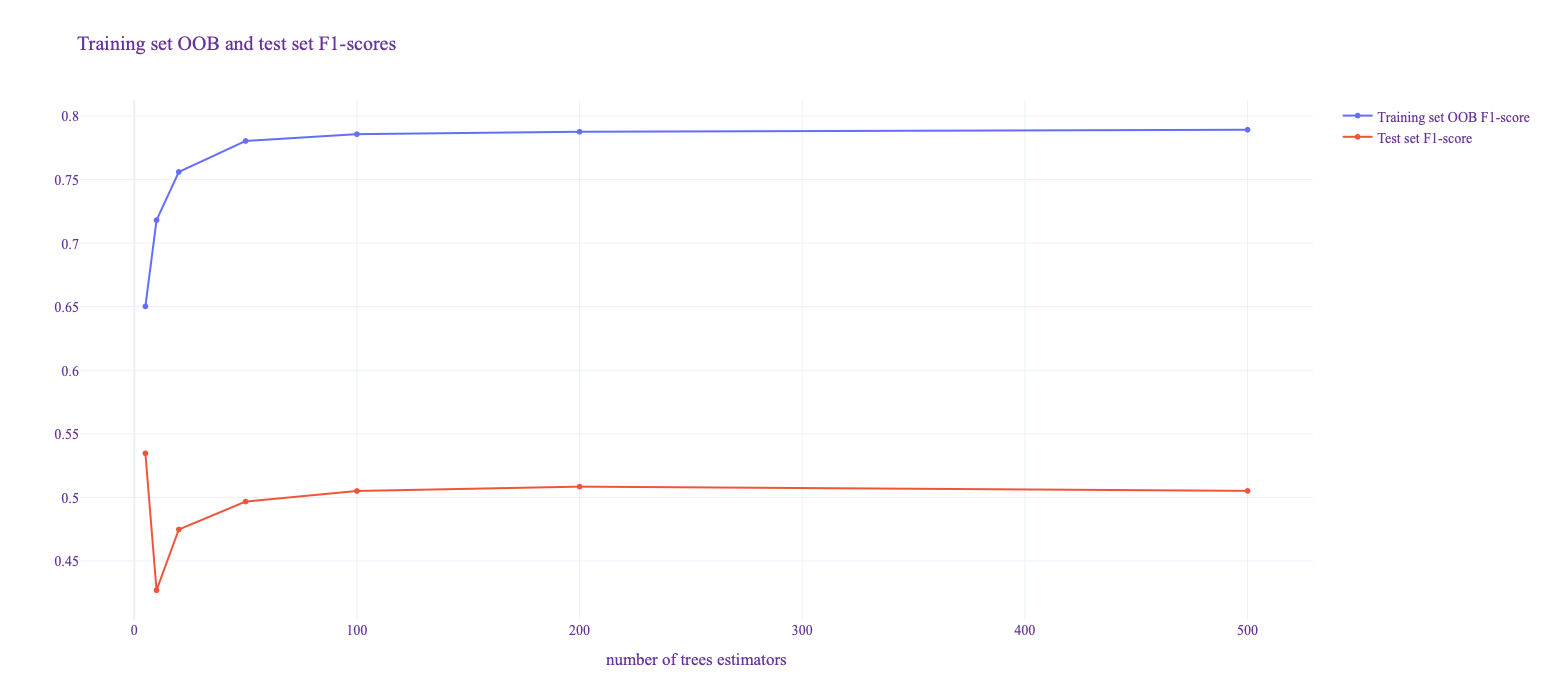

In [109]:
#------- HYPERPARAMETERS OPTIMIZATION -----#
# Optimal number of estimators (trees) based on accuracy and OOB error
oob_f1 = []
test_f1 = []

n_trees = [5, 10, 20, 50, 100, 200, 500]

for n_est in tqdm(n_trees):
    # Creating an instance of the random forest classifier
    rf_class = RandomForestClassifier(
        n_estimators=n_est,
        criterion="gini",
        oob_score=f1_score,
        min_samples_leaf=1,
        max_features= "sqrt",
        bootstrap=True, 
        random_state=42,
        n_jobs=-1
    )

    # Fitting the RF estimator on the training data and computing the OOB f1-score
    modelCla_iter1 = make_pipeline(feature_trans, rf_class)
    modelCla_iter1.fit(X_train, y_train)
    oob_f1.append(rf_class.oob_score_)
    
    # Computing the f1-score on the test set
    y_pred_iter1 = modelCla_iter1.predict(X_test)
    test_f1.append(f1_score(y_test, y_pred_iter1))

# Plot graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_trees, y=oob_f1, name="Training set OOB F1-score"))
fig.add_trace(go.Scatter(x=n_trees, y=test_f1, name="Test set F1-score"))
fig.update_layout(title="Training set OOB and test set F1-scores", xaxis_title="number of trees estimators",
                  font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)

fig.show()

Not much improvements for more than 100 trees. We therefore choose `n_estimators=100`

In [31]:
# Optimal classification probability threshold based on cross-validation
rf_class = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    oob_score=True,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True, 
    random_state=42,
    n_jobs=-1
)

modelCla_iter2 = make_pipeline(feature_trans, rf_class)

sub_idx = pd.Series(X.index).sample(frac=0.1)
score_df = test_clf_CV(modelCla_iter2, X.loc[X.index.isin(sub_idx),:], y[y.index.isin(sub_idx)])

  0%|          | 0/11 [00:00<?, ?it/s]

Fitting leaving month 1 out...
Best threshold found is: 0.58
Accuracy score is: 0.933
Precision score is: 0.579
Recall score is: 0.574
F1 score is: 0.577

Fitting leaving month 2 out...
Best threshold found is: 0.31
Accuracy score is: 0.898
Precision score is: 0.568
Recall score is: 0.779
F1 score is: 0.657

Fitting leaving month 3 out...
Best threshold found is: 0.38
Accuracy score is: 0.895
Precision score is: 0.606
Recall score is: 0.878
F1 score is: 0.717

Fitting leaving month 4 out...
Best threshold found is: 0.32
Accuracy score is: 0.907
Precision score is: 0.623
Recall score is: 0.882
F1 score is: 0.730

Fitting leaving month 5 out...
Best threshold found is: 0.38
Accuracy score is: 0.925
Precision score is: 0.659
Recall score is: 0.881
F1 score is: 0.754

Fitting leaving month 6 out...
Best threshold found is: 0.17
Accuracy score is: 0.891
Precision score is: 0.526
Recall score is: 0.732
F1 score is: 0.612

Fitting leaving month 7 out...
Best threshold found is: 0.33
Accuracy 

In [32]:
score_df.mean()

accuracy     0.893833
precision    0.588025
recall       0.799755
f1           0.674653
threshold    0.340909
dtype: float64

In [19]:
#----- DEFINITION OF THE CLASSIFICATION MODEL ------#
# if model is already saved in the directory, use the saved model, otherwise build a new one on inserted optimal hyperparams
n_est_opt = 100
thresh_opt = 0.2

retrain_anyway = True # overrides the previous condition

if not(os.path.isfile('modelClassifier.joblib')) or retrain_anyway:
    rf_class = RandomForestClassifier(
        n_estimators=n_est_opt,
        criterion="gini",
        oob_score=True,
        min_samples_leaf=1,
        max_features= "sqrt",
        bootstrap=True, 
        random_state=42,
        n_jobs=-1
    )
    
    modelCla = make_pipeline(feature_trans, rf_class)
    
    print("Training classifier...")
    modelCla.fit(X_train, y_train)
    #joblib.dump(modelCla, 'modelClassifier.joblib');# --> salvo il modello
else:
    modelCla = joblib.load('modelClassifier.joblib');

## Making the prediction with the classification model
print("Predicting with Classifier...")
y_pred = (modelCla.predict_proba(X_test)[:,1] >= thresh_opt).astype(bool)

Training classifier...
Predicting with Classifier...


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     29000
           1       0.71      0.92      0.80      6962

    accuracy                           0.91     35962
   macro avg       0.85      0.91      0.87     35962
weighted avg       0.93      0.91      0.92     35962



In [68]:
small_train_period = X.index.str[3:5].astype(int) < 3
small_test_period = X.index.str[3:5].astype(int) == 3

X_train_small = X[small_train_period]
y_train_small = y[small_train_period]

X_test_small = X[small_test_period]
y_test_small = y[small_test_period]

rf_class = RandomForestClassifier(
        n_estimators=n_est_opt,
        criterion="gini",
        oob_score=True,
        min_samples_leaf=1,
        max_features= "sqrt",
        bootstrap=True, 
        random_state=42,
        n_jobs=-1
    )
    
modelCla = make_pipeline(feature_trans, rf_class)

predict_probs = predict_proba_daily_recal(modelCla, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

y_pred_small = (predict_probs[:,1] >= thresh_opt).astype(bool)
print(classification_report(y_test_small, y_pred_small))

  0%|          | 0/153 [00:00<?, ?it/s]

F1-score for day 2019-07-01 00:00:00 is 0.5114345114345114
[[1484  220]
 [  15  123]]


F1-score for day 2019-07-02 00:00:00 is 0.5278276481149012
[[1553  249]
 [  14  147]]


F1-score for day 2019-07-03 00:00:00 is 0.17261904761904762
[[1576  274]
 [   4   29]]


F1-score for day 2019-07-04 00:00:00 is 0.4393063583815029
[[1705  177]
 [  17   76]]


F1-score for day 2019-07-05 00:00:00 is 0.34557235421166305
[[1575  296]
 [   7   80]]


F1-score for day 2019-07-06 00:00:00 is 0.5647058823529413
[[1314  245]
 [  14  168]]


F1-score for day 2019-07-07 00:00:00 is 0.6849816849816851
[[1116  158]
 [  14  187]]


F1-score for day 2019-07-08 00:00:00 is 0.5185185185185186
[[1630  185]
 [  36  119]]


F1-score for day 2019-07-09 00:00:00 is 0.4493827160493827
[[1682  194]
 [  29   91]]


F1-score for day 2019-07-10 00:00:00 is 0.3896713615023474
[[1531  252]
 [   8   83]]


F1-score for day 2019-07-11 00:00:00 is 0.5051334702258727
[[1475  227]
 [  14  123]]


F1-score for day 2019-07-12 00

ValueError: Found input variables with inconsistent numbers of samples: [39159, 202789]

In [107]:
with open("predict_probs_series.pkl", 'rb') as file:
    y_probs = pickle.load(file)
y_probs

idx
01/07/201917UP_SLDGLRENZA_2    0.0
01/07/201917UP_SND_ALBAN_1     0.0
01/07/201917UP_SND_CAMPO_1     0.0
01/07/201917UP_SOVERZENE_1     0.0
01/07/201917UP_VALMALENCO_1    0.0
                              ... 
30/11/201910UP_ETQCHIOTAS_1    0.0
30/11/201910UP_EDOLO_1         0.0
30/11/201910UP_CURON_ME_1      0.0
30/11/201910UP_CMPLCCIOLI_2    0.0
30/11/201910UP_ETQ_ROVINA_1    0.0
Length: 202789, dtype: float64

In [108]:
y_probs = y_probs[y_probs.index.str[3:5]=='11']

In [109]:
# Optimal classification probability threshold based on OOB
idx = 0

start = 1
end = 99
step = 1

precision = []
recall = []
mcc = []
accuracy = []
f1 = []
threshold = []


for prob_thre in trange(start, end, step):
    
    y_pred_iter2 = (y_probs >= prob_thre / 100).astype(bool)

    precision.append(precision_score(y_test, y_pred_iter2))
    recall.append(recall_score(y_test, y_pred_iter2))
    mcc.append(matthews_corrcoef(y_test, y_pred_iter2))
    accuracy.append(accuracy_score(y_test, y_pred_iter2))
    f1.append(f1_score(y_test, y_pred_iter2))
    
    threshold.append(prob_thre/100)

  0%|          | 0/98 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



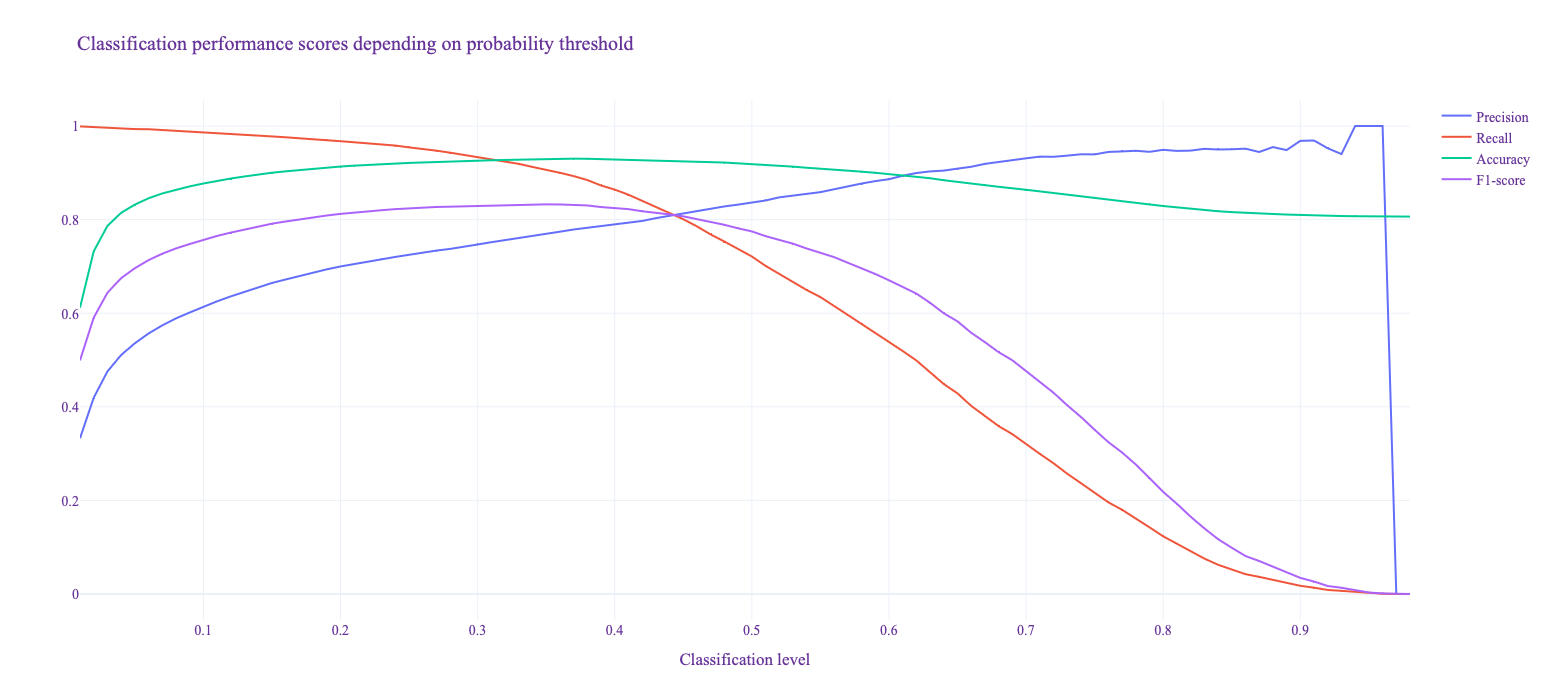

In [110]:
# Plot graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=threshold, y=precision, name="Precision"))
fig.add_trace(go.Scatter(x=threshold, y=recall, name="Recall"))
fig.add_trace(go.Scatter(x=threshold, y=accuracy, name="Accuracy"))
fig.add_trace(go.Scatter(x=threshold, y=f1, name="F1-score"))
fig.update_layout(title="Classification performance scores depending on probability threshold",
                  xaxis_title="Classification level",
                  font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

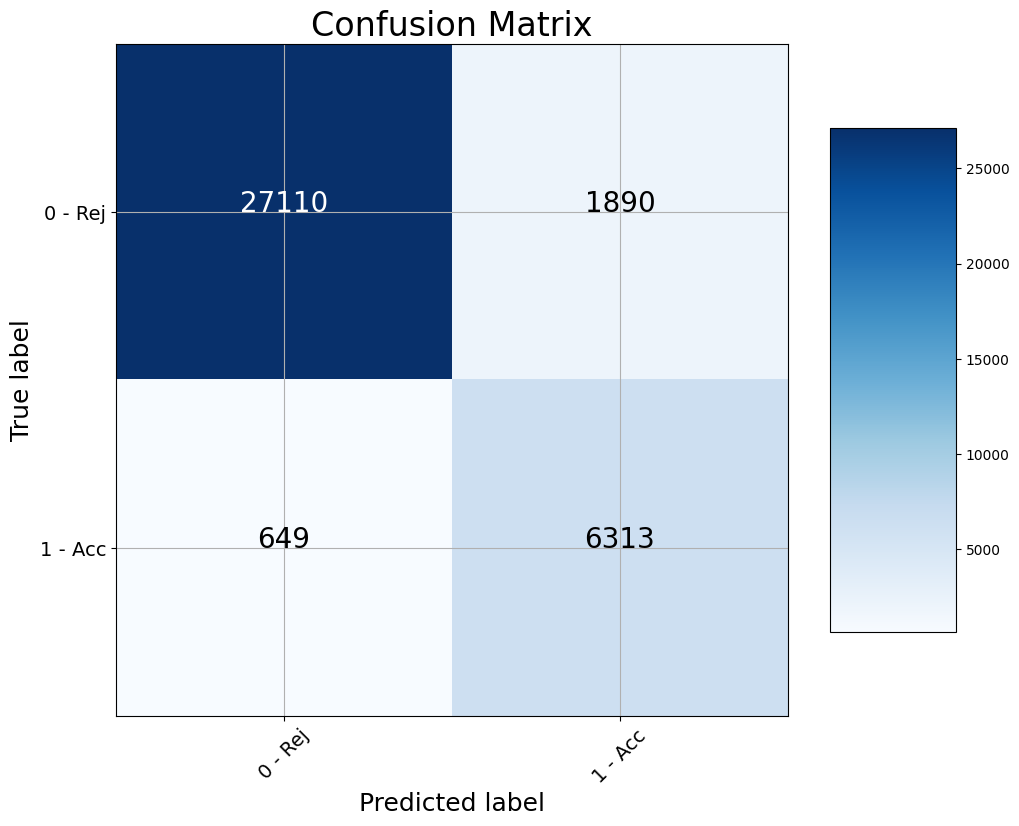

In [112]:
plot_confusion_matrix(confusion_matrix(y_test, (y_probs >= 0.35)), classes = ['0 - Rej', '1 - Acc'], title = 'Confusion Matrix')

In [113]:
print(classification_report(y_test, (y_probs >= 0.35)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     29000
           1       0.77      0.91      0.83      6962

    accuracy                           0.93     35962
   macro avg       0.87      0.92      0.89     35962
weighted avg       0.94      0.93      0.93     35962



In [114]:
y_pred = y_probs >= 0.35

The accuracy of the model is 92.9 %
The OOB error of the model is 5.4 %
Train ROC AUC Score: 0.9999433685942989
Test ROC AUC  Score: 0.97306254395784


/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Recall Baseline: 0.0 Test: 0.907 Train: 0.987
Precision Baseline: 0.0 Test: 0.77 Train: 0.99
Roc Baseline: 0.5 Test: 0.973 Train: 1.0


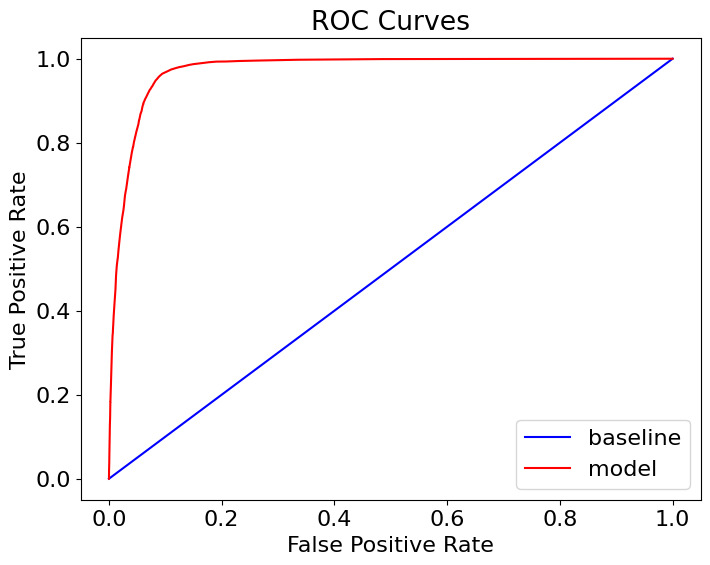

In [124]:
### 2) Evaluate the classification model ### 
## Evaluate the classification model: accuracy, recall, precision, ROC AUC, confusion matrix
# accuracy
print(f"The accuracy of the model is {round(accuracy_score(y_test, y_pred),3)*100} %") # formatted string literal or f-string
# OOB score
print(f"The OOB error of the model is {round(1 - rf_class.oob_score_, 3) * 100} %") # formatted string literal or f-string

# ROC AUC
# costruisco le distribuzioni di probabilità prevista per train e test datasets 
# (lo faccio sulla classe rappresentata dall'intero maggiore (1), che coincide con i positivi, avrò quindi le distribuzioni dei falsi e veri positivi)
train_probs = modelCla.predict_proba(X_train)[:,1] 
probs = y_probs.copy()
# predizioni sul training
train_predictions = modelCla.predict(X_train)
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

# plotting the ROC curve
def evaluate_model(y_pred, probs, train_predictions, train_probs):
    # base
    baseline = {}
    baseline_probs = [sum(y_train) / len(y_train)] * len(y_test)
    baseline_pred = np.array(baseline_probs) > 0.5
    baseline['recall']=recall_score(y_test, baseline_pred)
    baseline['precision'] = precision_score(y_test, baseline_pred)
    baseline['roc'] = roc_auc_score(y_test, baseline_probs)
    # test
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    # train
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 3)} Test: {round(results[metric], 3)} Train: {round(train_results[metric], 3)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, baseline_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model') # probabilities of the test dataset
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs)

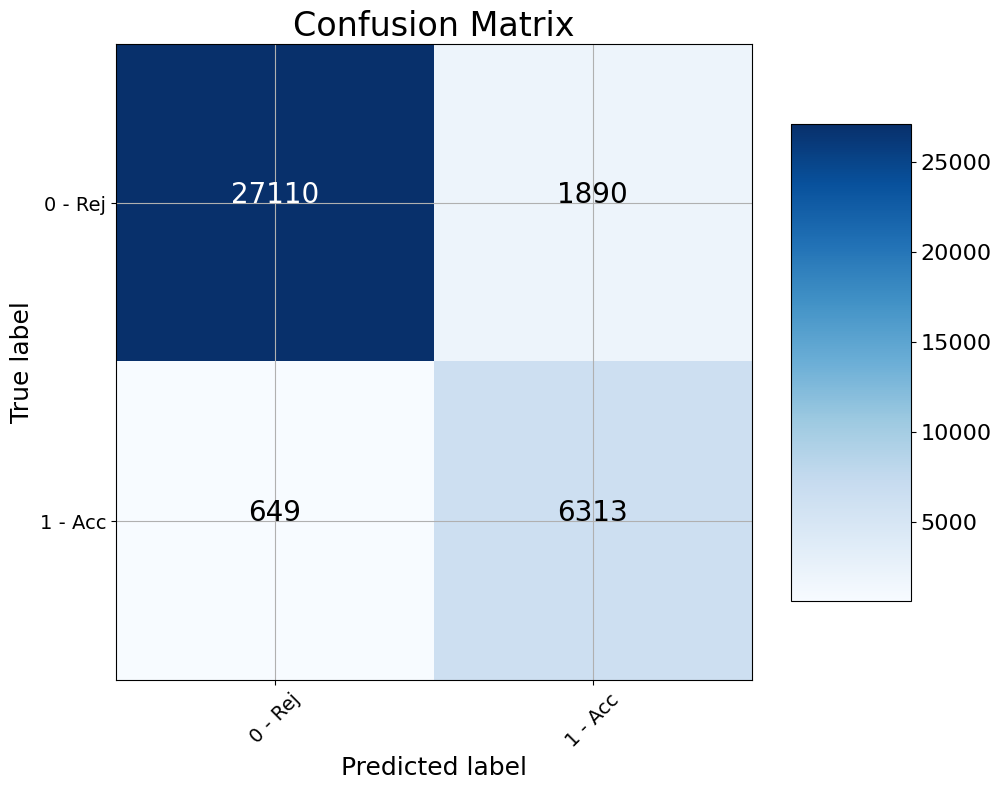

In [125]:
# CONSFUSION MATRIX
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Rej', '1 - Acc'], title = 'Confusion Matrix')

 There are 89 features in total
Feature: Prov_Bergamo                        Importance: 8.477123295398749e-05
Feature: Prov_Genova                         Importance: 8.58448438392734e-05
Feature: Prov_Pordenone                      Importance: 9.928460182666845e-05
Feature: Prov_Vicenza                        Importance: 0.00018994573515605386
Feature: MargTech_Tg                         Importance: 0.00023284540700478564
Feature: Prov_Como                           Importance: 0.00032600274288671426
Feature: Prov_La Spezia                      Importance: 0.0003861848431964075
Feature: Prov_Reggio Emilia                  Importance: 0.0003902179612512732
Feature: Prov_Verbano-Cusio-Ossola           Importance: 0.0004611805801928799
Feature: Prov_Treviso                        Importance: 0.0005015536298485071
Feature: Prov_Novara                         Importance: 0.0006003626478694545
Feature: MargTech_Fer                        Importance: 0.0006152369784924765
Feature: MargTech_

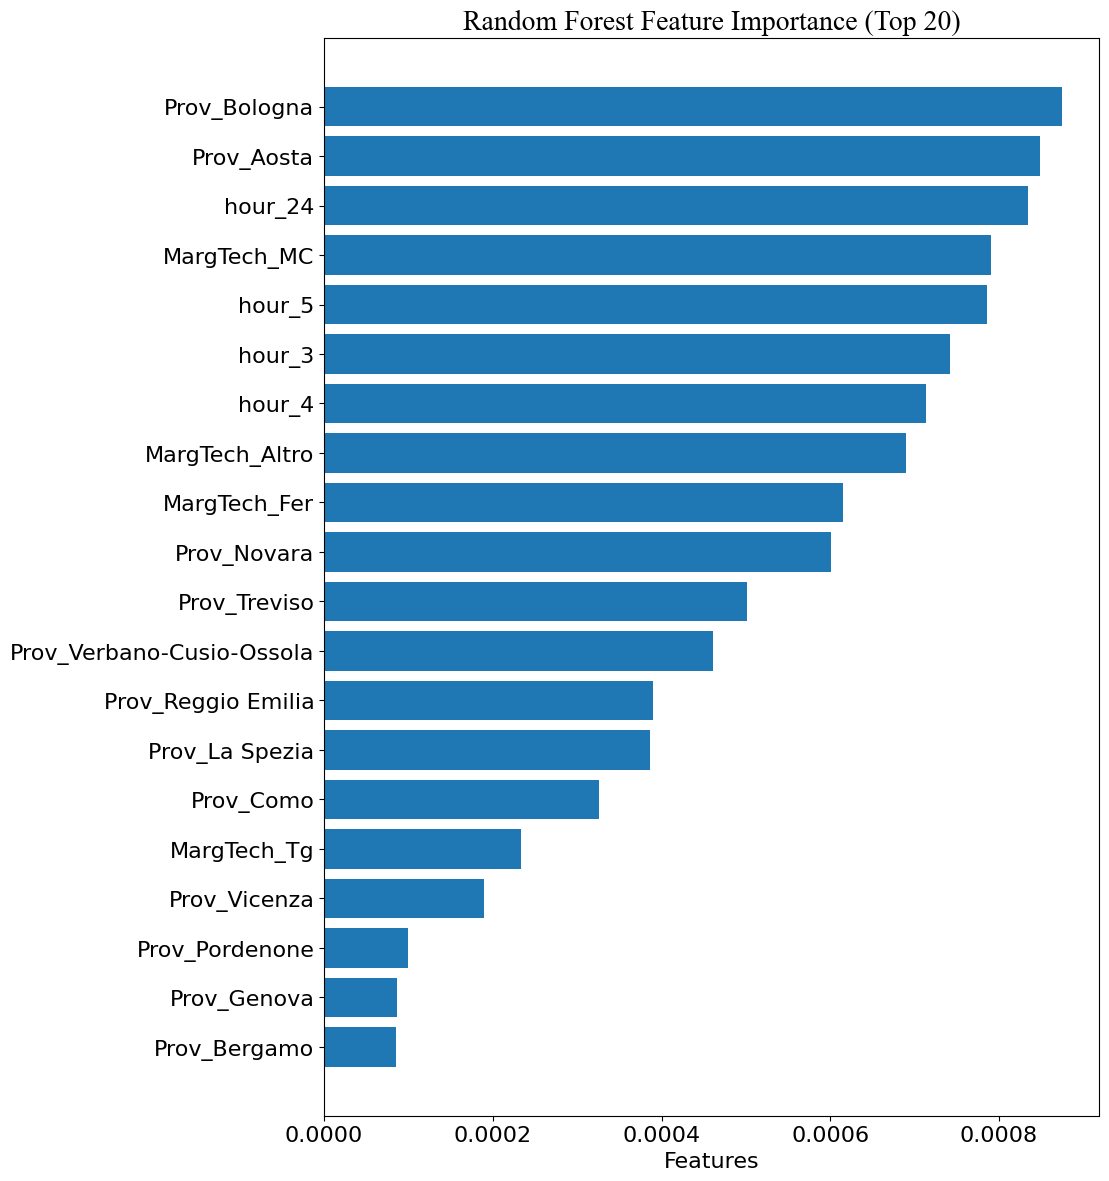

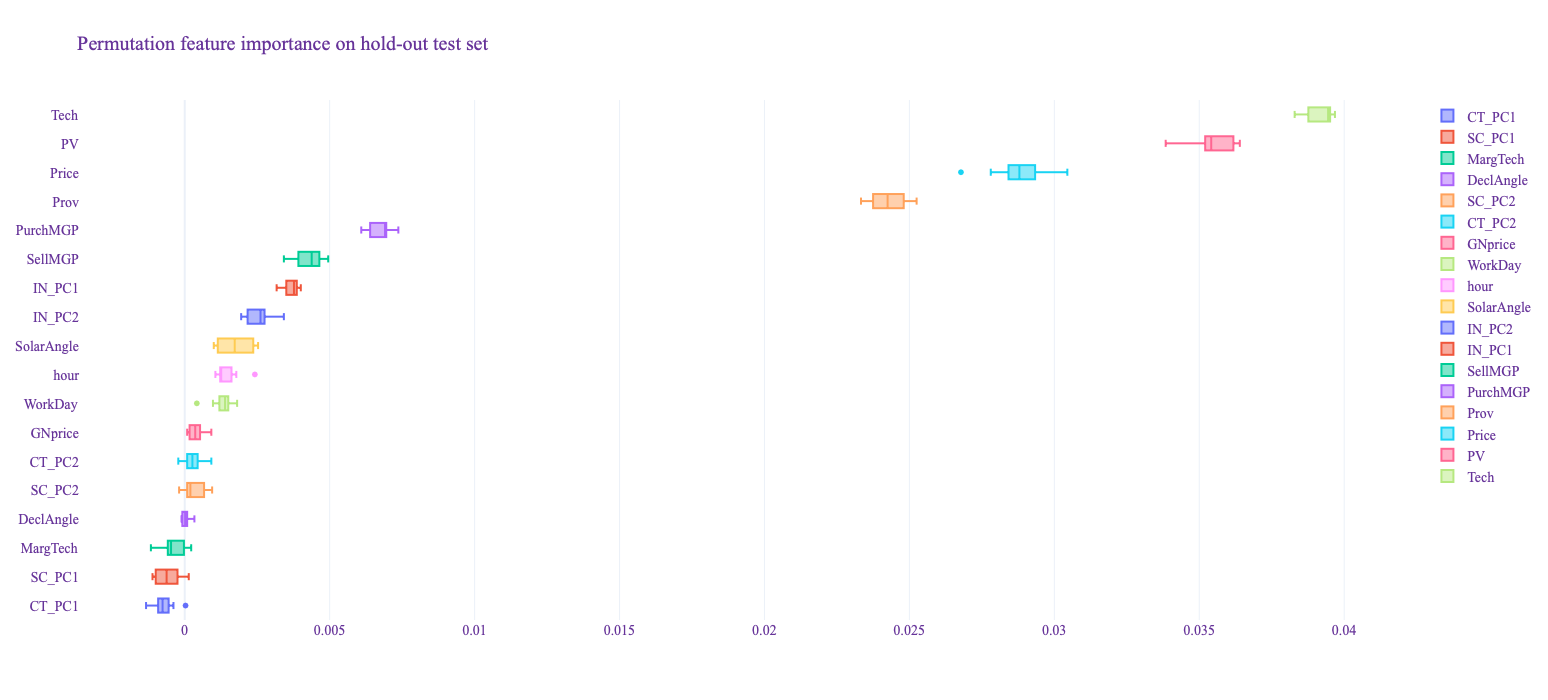

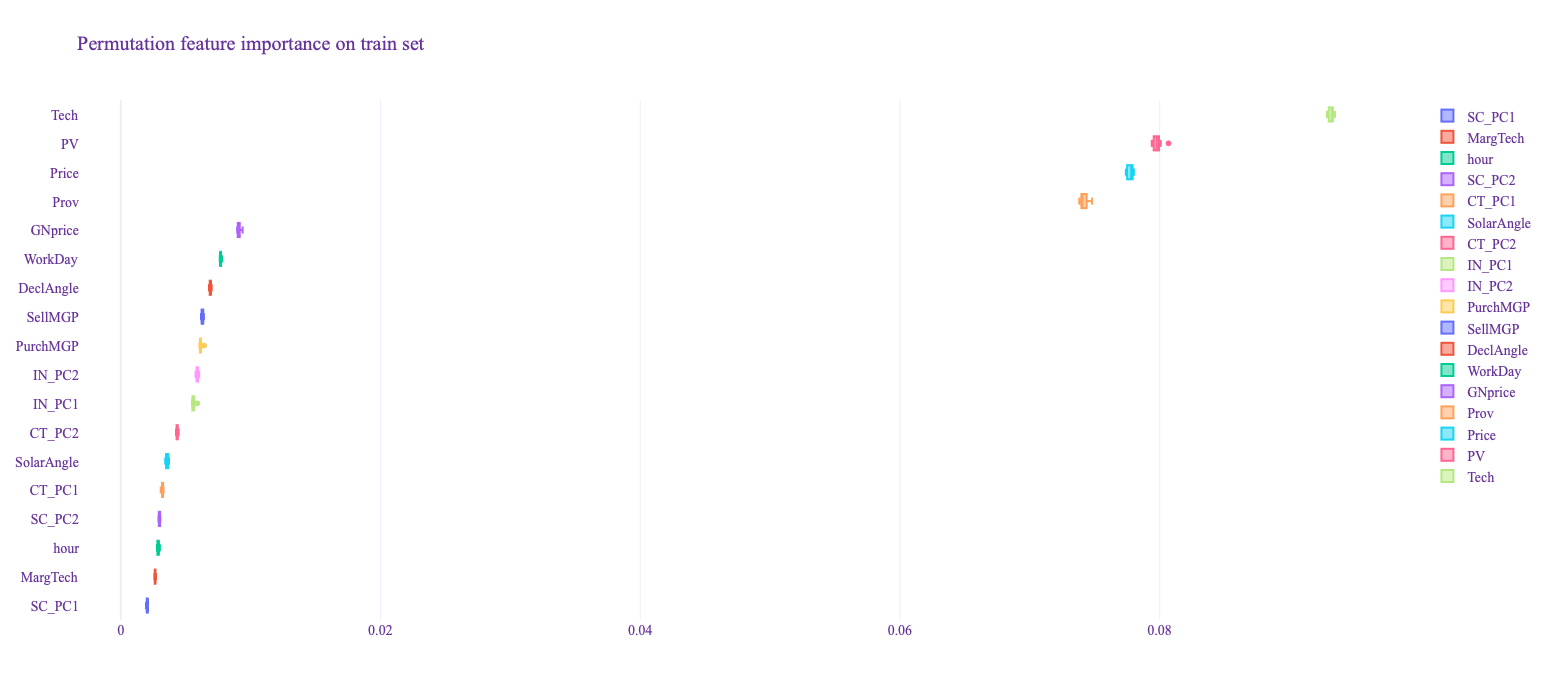

In [126]:
### 3) Feature Importance ###
#------------- Impurity based (depends on impurity used in model training) -------------####
#print(rf_class.feature_importances_)
print(f" There are {len(rf_class.feature_importances_)} features in total") # extra features wrt to train dataset columns are due to encoding
# (need to rebuild the original features to evaluate the importance)

#print(feature_trans.fit_transform(X_train)[0,:])
#print(X_train.iloc[0])
#print("# You see numerical variables are at the end")

def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, categorical_features) # X_train with encoded categorical features

feature_importances = list(zip(X_train_encoded, rf_class.feature_importances_))
# riordino in ordine decrescente di importanza
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = False)
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked]
# plotting the freature importance (top 20)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 20)', fontdict= {'fontname':'Times New Roman','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

###------------ Permutation Feature Importance ------------####
# Hold-out test set
perm_feat_test = permutation_importance(modelCla, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = perm_feat_test.importances_mean.argsort()
fig = go.Figure()
for i in range(len(sorted_idx)):
    fig.add_trace(go.Box(x=perm_feat_test.importances[sorted_idx[i]].T,name=X_test.columns[sorted_idx[i]]))
#fig.add_trace(go.Box(x=X_test.columns[sorted_idx[1]]))
fig.update_layout(title="Permutation feature importance on hold-out test set",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

# Training set
perm_feat_train = permutation_importance(modelCla, X_train, y_train, n_repeats=10,random_state=42, n_jobs=2)
sorted_idx = perm_feat_train.importances_mean.argsort()
fig = go.Figure()
for i in range(len(sorted_idx)):
    fig.add_trace(go.Box(x=perm_feat_train.importances[sorted_idx[i]].T,name=X_test.columns[sorted_idx[i]]))
#fig.add_trace(go.Box(x=X_test.columns[sorted_idx[1]]))
fig.update_layout(title="Permutation feature importance on train set",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

From the output of the Permutation Feature Importance (PFI), we can clearly identify a group of four variables that reflect the model behaviour:
- `Tech` (technology of the power unit)
- `PV` (value between 0 and 1 indicating the ratio of the actual power on the maximum power)
- `Price` (price proposed per MWh)
- `Prov` (Province in which the power plant is located)

Let's now inspect the more precise behaviour with the Partial Dependence Plots (PDPs)

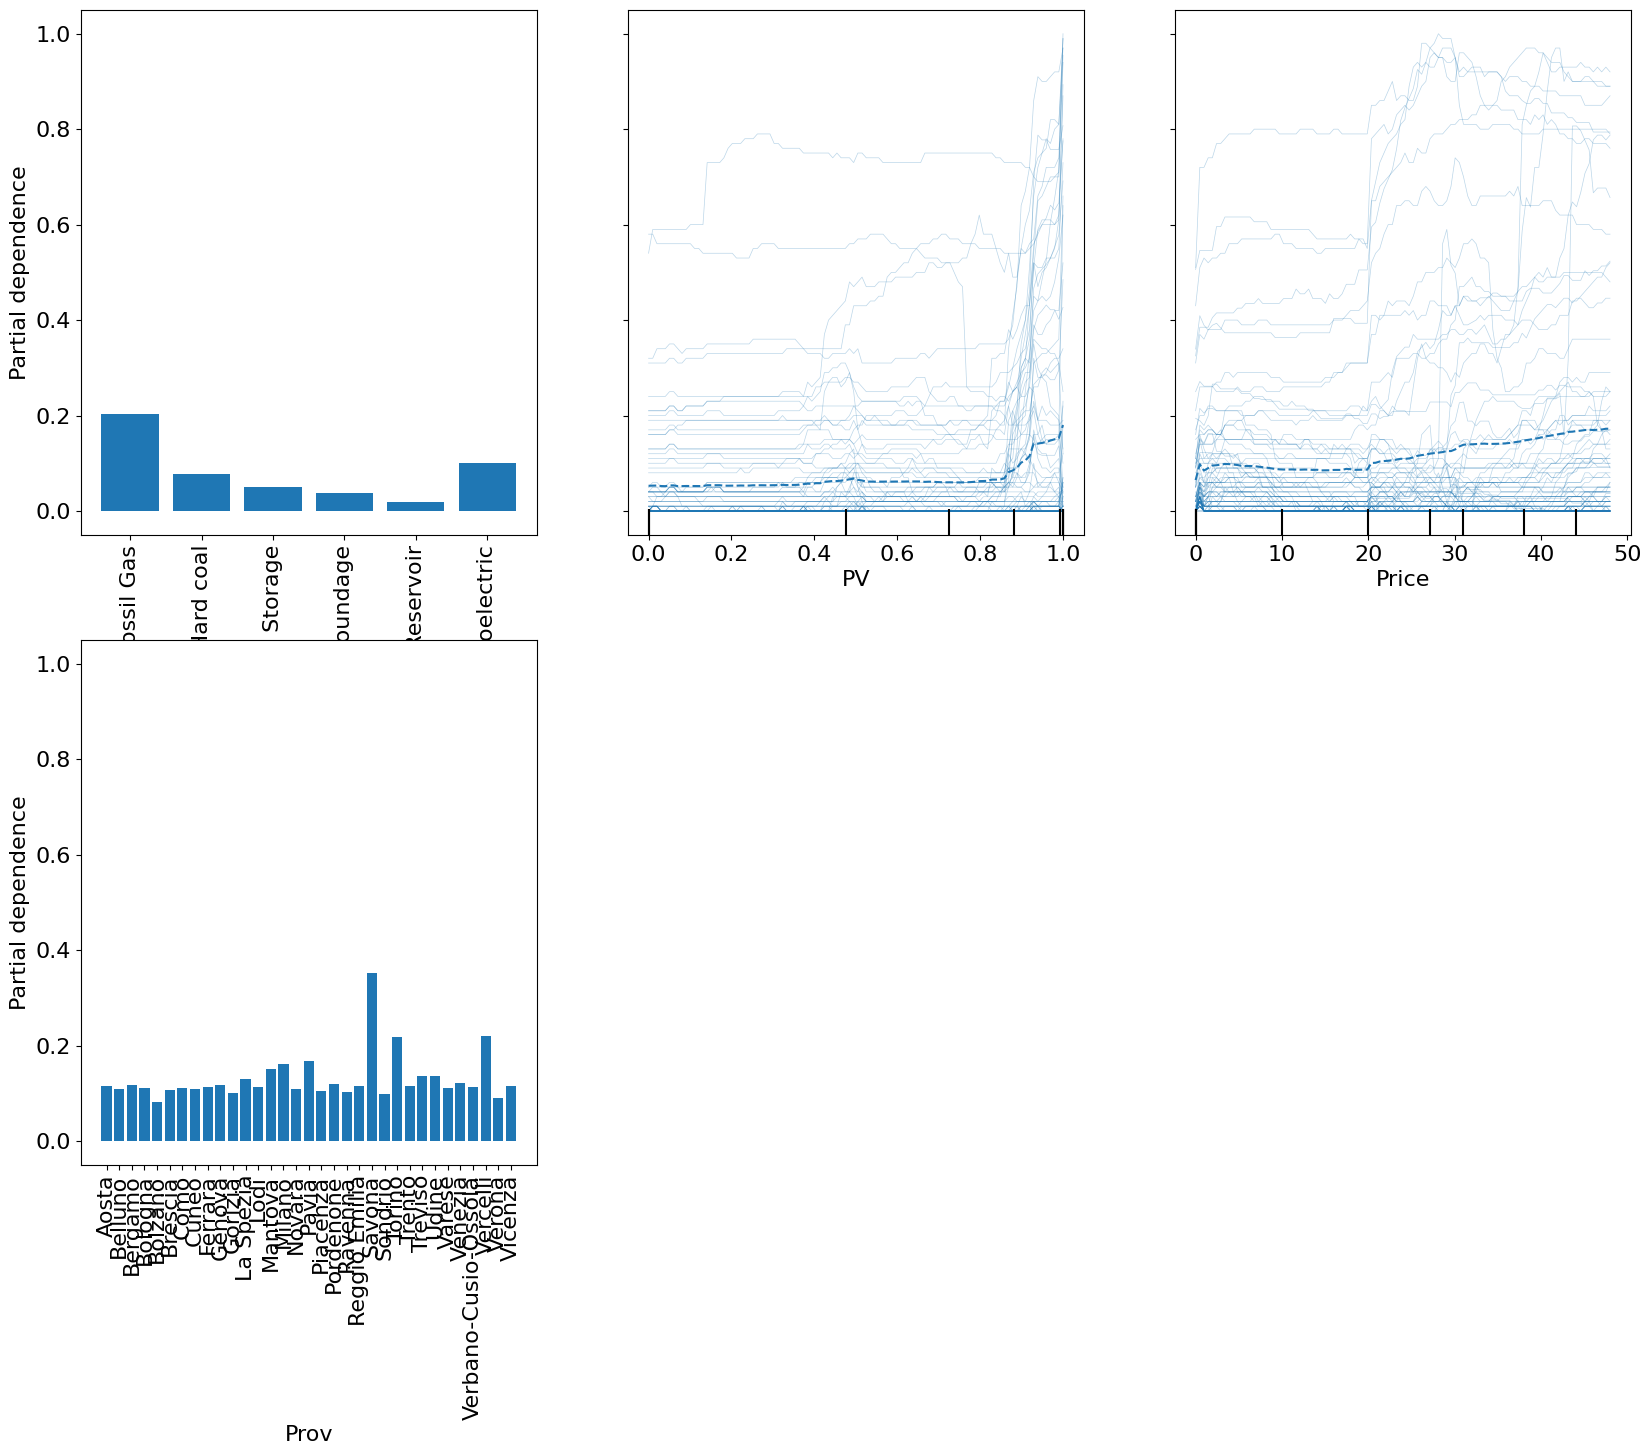

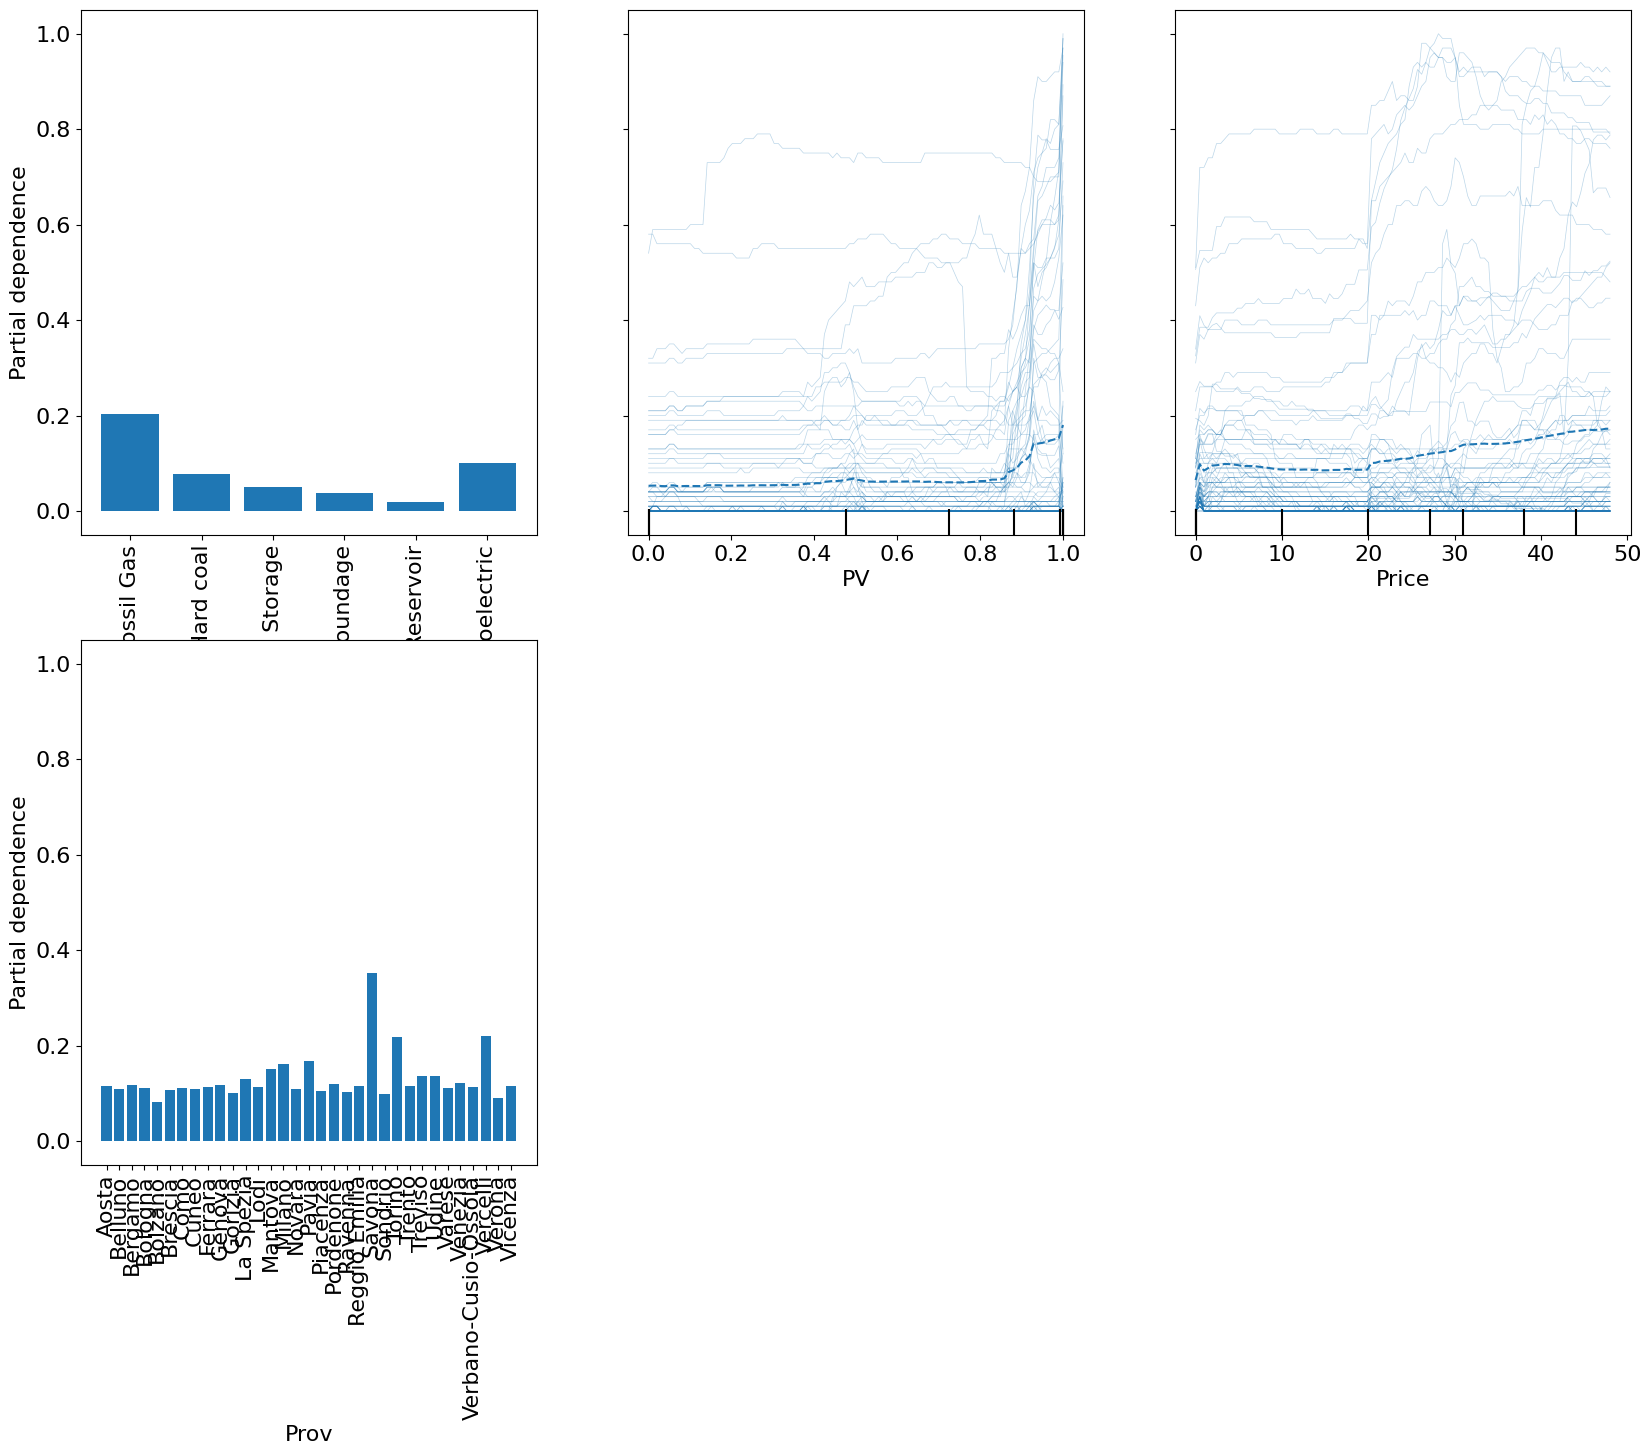

In [150]:
# Partial Dependence Plots (PDPs)
disp = PartialDependenceDisplay.from_estimator(
    modelCla,
    X = X_train,
    features = ['Tech', 'PV', 'Price', 'Prov'],
    categorical_features = np.array([col in categorical_features for col in X_train.columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'both', 'both', 'average'],
    subsample = 100
)

disp.figure_.set_size_inches(20, 15)
disp.figure_

## Final estimation on hold-out test set

In [126]:
DB

,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,Target,Result
idx,,,,,,,,,,,,,,,,,,,,
01/01/20191UP_BARGI_CEN_1,1,3.353367,0.050663,-3.76401,0.464396,-1.042284,2.704958,11460.324,9179.693,Ccgt,23.11,-178.226106,-23.011637,holiday,Bologna,Hydro Pumped Storage,0.0,0.0,0.0,0.0
01/01/201918UP_RIVADEL_3,18,0.155675,2.293847,-1.741667,0.780216,-1.36499,2.341325,14666.724,11233.886,Ccgt,23.11,76.773894,-23.011637,holiday,Trento,Hydro Pumped Storage,0.0,13.0,0.0,0.0
01/01/201918UP_RONCOVALG_1,18,0.155675,2.293847,-1.741667,0.780216,-1.36499,2.341325,14666.724,11233.886,Ccgt,23.11,76.773894,-23.011637,holiday,Varese,Hydro Pumped Storage,1.0,0.0,0.0,0.0
01/01/201918UP_ROVESCA_1,18,0.155675,2.293847,-1.741667,0.780216,-1.36499,2.341325,14666.724,11233.886,Ccgt,23.11,76.773894,-23.011637,holiday,Verbano-Cusio-Ossola,Hydro Pumped Storage,0.421567,0.0,0.0,0.0
01/01/201918UP_S.FIORANO_1,18,0.155675,2.293847,-1.741667,0.780216,-1.36499,2.341325,14666.724,11233.886,Ccgt,23.11,76.773894,-23.011637,holiday,Lodi,Hydro Pumped Storage,0.1963,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30/11/201910UP_ETQCHIOTAS_1,10,0.619961,0.319571,0.087942,-0.109236,0.095263,-0.865934,19038.53,15122.495,Carbone,16.303,-39.714944,-21.969868,holiday,Cuneo,Hydro Pumped Storage,0.0,46.56,0.0,0.0
30/11/201910UP_EDOLO_1,10,0.619961,0.319571,0.087942,-0.109236,0.095263,-0.865934,19038.53,15122.495,Carbone,16.303,-39.714944,-21.969868,holiday,Brescia,Hydro Pumped Storage,0.165851,0.0,0.0,0.0
30/11/201910UP_CURON_ME_1,10,0.619961,0.319571,0.087942,-0.109236,0.095263,-0.865934,19038.53,15122.495,Carbone,16.303,-39.714944,-21.969868,holiday,Bolzano,Hydro Run-of-river and poundage,0.583333,0.0,0.0,0.0


In [134]:
X_train = DB.drop('Result', axis=1)
y_train = DB['Result'].astype('int')

X_test = test_DB.drop('Result', axis=1)
y_test = test_DB['Result'].astype('int')

X_test = X_test.drop('Target', axis=1)
X_train = X_train.drop('Target', axis=1)

In [137]:
y_probs = predict_proba_daily_recal(modelCla, X_train, y_train, X_test, y_test)

  0%|          | 0/31 [00:00<?, ?it/s]

F1-score for day 2019-12-01 00:00:00 is 0.9543147208121827
[[910   5]
 [ 13 188]]


F1-score for day 2019-12-02 00:00:00 is 0.8365384615384615
[[1034   84]
 [  18  261]]


F1-score for day 2019-12-03 00:00:00 is 0.6956521739130436
[[1113  169]
 [   6  200]]


F1-score for day 2019-12-04 00:00:00 is 0.8398692810457516
[[1083   83]
 [  15  257]]


F1-score for day 2019-12-05 00:00:00 is 0.776068376068376
[[1063  123]
 [   8  227]]


F1-score for day 2019-12-06 00:00:00 is 0.8413547237076648
[[1020   79]
 [  10  236]]


F1-score for day 2019-12-07 00:00:00 is 0.9481481481481481
[[811  21]
 [  7 256]]


F1-score for day 2019-12-08 00:00:00 is 0.9289340101522843
[[698  24]
 [  4 183]]


F1-score for day 2019-12-09 00:00:00 is 0.7932330827067668
[[894  99]
 [ 11 211]]


F1-score for day 2019-12-10 00:00:00 is 0.8514190317195325
[[977  80]
 [  9 255]]


F1-score for day 2019-12-11 00:00:00 is 0.9271523178807947
[[975  20]
 [ 24 280]]


F1-score for day 2019-12-12 00:00:00 is 0.801901743264659

In [141]:
y_probs = pd.Series(y_probs[:,1], index=y_test.index)
with open("predict_probs_series_december.pkl", 'wb') as file:
    pickle.dump(y_probs, file)

In [142]:
y_pred = y_probs >= 0.35
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     29589
           1       0.80      0.91      0.85      6688

    accuracy                           0.94     36277
   macro avg       0.89      0.93      0.91     36277
weighted avg       0.95      0.94      0.94     36277



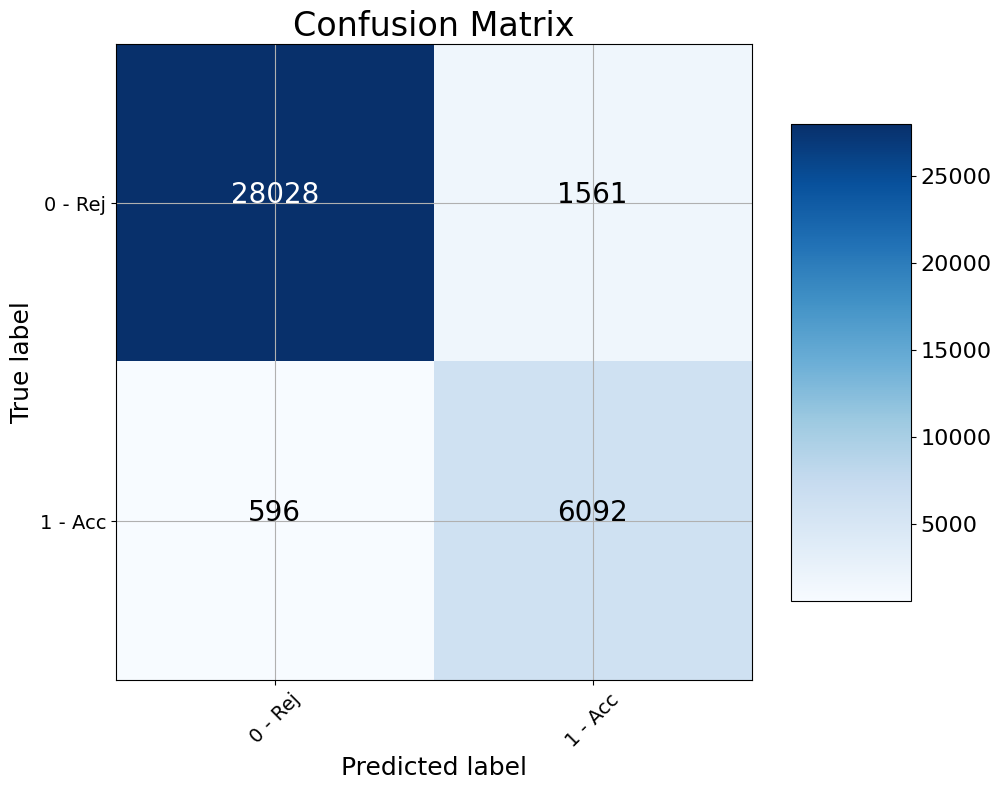

In [146]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Rej', '1 - Acc'], title = 'Confusion Matrix')

In [148]:
# Time Series Cross Validation metrics
test_dates = pd.to_datetime(y_test.index.str[:10], format="%d/%m/%Y")
distinct_dates = test_dates.unique()

precision = []
recall = []
mcc = []
accuracy = []
f1 = []


for date in tqdm(distinct_dates):
    y_test_day = y_test[test_dates == date]
    y_pred_day = y_pred[test_dates == date]
    
    precision.append(precision_score(y_test_day, y_pred_day))
    recall.append(recall_score(y_test_day, y_pred_day))
    mcc.append(matthews_corrcoef(y_test_day, y_pred_day))
    accuracy.append(accuracy_score(y_test_day, y_pred_day))
    f1.append(f1_score(y_test_day, y_pred_day))

  0%|          | 0/31 [00:00<?, ?it/s]

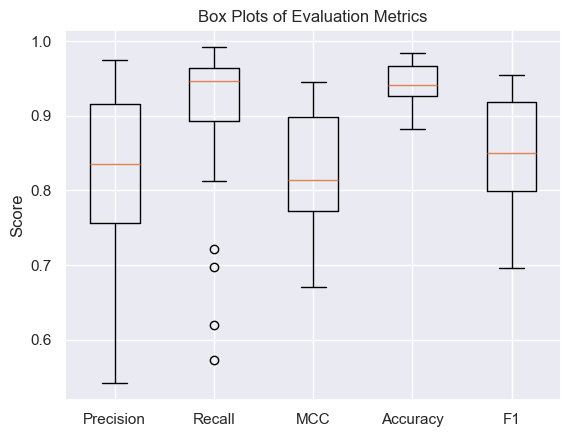

In [158]:
fig, ax = plt.subplots()

# Create box plots for each list aligned horizontally
boxplots = ax.boxplot([precision, recall, mcc, accuracy, f1], labels=['Precision', 'Recall', 'MCC', 'Accuracy', 'F1'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Box Plots of Evaluation Metrics')

# Show the plot
plt.show()